In [6]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [7]:
from mnist import MNIST
print("Loading dataset....")
mndata = MNIST('../mnist_dataset')
X_train, y_train = mndata.load_training()
X_train = (mndata.process_images_to_numpy(X_train)/255).astype(np.float32)
X_test, y_test = mndata.load_testing()
X_test = (mndata.process_images_to_numpy(X_test)/255).astype(np.float32)
print("Done.")

Loading dataset....
Done.


In [8]:
del y_train
del y_test
del mndata
# for tanh
X_train=X_train*2 - 1
X_test=X_test*2 - 1
X_train=np.concatenate([X_train,X_test]).reshape(-1,28,28,1)

In [1]:
import sys
sys.path.append("../dnn_from_scratch")

In [2]:
from nnet_gpu.network import Sequential
from nnet_gpu.layers import Conv2D,MaxPool,Flatten,Dense,Dropout,Conv2Dtranspose,Upsampling,Reshape,BatchNormalization,Activation
from nnet_gpu import functions
from nnet_gpu import optimizers
import numpy as np
import cupy as cp

In [4]:
def generator():
    model=Sequential()
    model.add(Dense(128*7*7,activation=functions.leakyRelu,input_shape=100))
    model.add(Reshape((7,7,128)))
#     model.add(Upsampling())
#     model.add(Conv2D(64,kernel_size=3,activation=functions.leakyRelu))
    model.add(Conv2Dtranspose(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
#     model.add(Upsampling())
#     model.add(Conv2D(32,kernel_size=3,activation=functions.leakyRelu))
    model.add(Conv2Dtranspose(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
    model.add(BatchNormalization())
    model.add(Conv2D(1,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- InputLayer(InputLayer)  (None, 100)                echo             0
__________________________________________________________________________________________
0 Dense(Dense)            (None, 6272)               leakyRelu        633472
__________________________________________________________________________________________
1 Reshape(Reshape)        (None, 7, 7, 128)          echo             0
__________________________________________________________________________________________
2 Conv2Dtranspose(Conv2Dt (None, 14, 14, 64)         leakyRelu        73792
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 14, 14, 64)         echo             256
__________________________________________________________________________________________
4 Con

In [5]:
def discriminator():
    model=Sequential()
    model.add(Conv2D(32,kernel_size=3,stride=[2,2],activation=functions.leakyRelu,input_shape=(28,28,1)))
#     model.add(MaxPool())
    model.add(Dropout(0.25))
    model.add(Conv2D(64,kernel_size=3,stride=[2,2],activation=functions.leakyRelu))
#     model.add(MaxPool())
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256,activation=functions.leakyRelu))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- InputLayer(InputLayer)  (None, 28, 28, 1)          echo             0
__________________________________________________________________________________________
0 Conv2D(Conv2D)          (None, 14, 14, 32)         leakyRelu        320
__________________________________________________________________________________________
1 Dropout(Dropout)        (None, 14, 14, 32)         echo             0
__________________________________________________________________________________________
2 Conv2D(Conv2D)          (None, 7, 7, 64)           leakyRelu        18496
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 7, 7, 64)           echo             256
__________________________________________________________________________________________
4 Dropou

In [9]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.002)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy,learning_rate=0.002)

In [10]:
noise=cp.random.randn(64,100,dtype=cp.float32)
gen=g.predict(noise)

In [11]:
def gen_sample():
    noise=cp.random.randn(1,100,dtype=cp.float32)
    gen=g.predict(noise)
    plt.imshow(((gen.reshape(28,28)+1)/2).get(), cmap='Greys')
    plt.show()
    print(d.predict(gen)[0])

In [12]:
X_train=cp.asarray(X_train)

In [13]:
def run(batch_size=64):
    dsz=X_train.shape[0]
    # Label real ones as 90% real
    y_fake=cp.zeros((batch_size,1),dtype=cp.float32)
    y_real=cp.ones((batch_size,1),dtype=cp.float32)
    y_gen=cp.ones((batch_size,1),dtype=cp.float32)
    for step in range(dsz//batch_size):
        stt=time()
        noise=cp.random.randn(batch_size,100,dtype=cp.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Get random real images
        real_images=X_train[cp.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
#         X = cp.concatenate([real_images,generated_images])
        # Train discriminator
        y_real=cp.random.uniform(0.9,1,(batch_size,1),dtype=cp.float32)
        y_fake=cp.random.uniform(0,0.1,(batch_size,1),dtype=cp.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
        noise=cp.random.randn(batch_size,100,dtype=cp.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%60:
            gen_sample()
        print("\rProgress: {:.2f} %     Dloss: {}    err: {}     Sample time: {:.3f}s    _".format(step*batch_size*100/dsz,dloss,abs(err).sum(),time()-stt),end='')

EPOCH: 1 / 5


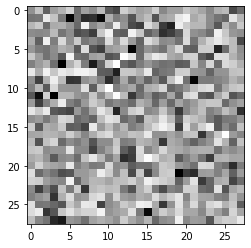

[0.54633003]
Progress: 1.35 %     Dloss: 7.820592    err: 807.4297     Sample time: 0.040s    ___

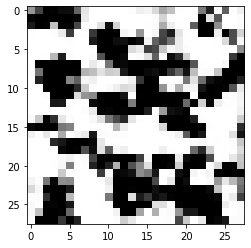

[0.5276597]
Progress: 2.72 %     Dloss: 8.213522    err: 2866.953     Sample time: 0.044s    ___

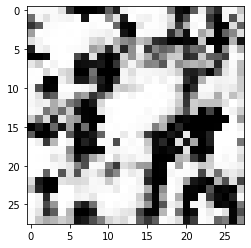

[0.10289502]
Progress: 4.09 %     Dloss: 14.27276    err: 4914.824     Sample time: 0.050s    _ _

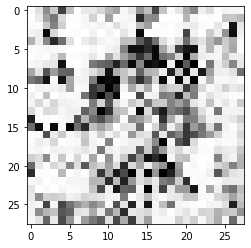

[0.03284461]
Progress: 5.46 %     Dloss: 9.010208    err: 3919.1514     Sample time: 0.040s    ___

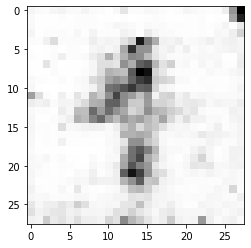

[0.05831813]
Progress: 6.83 %     Dloss: 11.536997    err: 1117.0536     Sample time: 0.048s    _

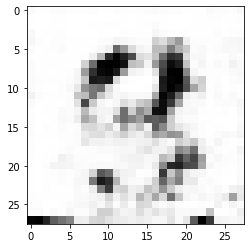

[0.48987067]
Progress: 8.21 %     Dloss: 9.553229    err: 1168.1736     Sample time: 0.050s    ___

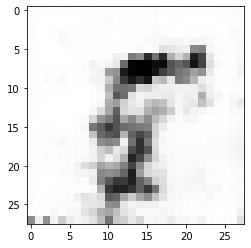

[0.42678332]
Progress: 9.58 %     Dloss: 12.354365    err: 904.091     Sample time: 0.040s    ____

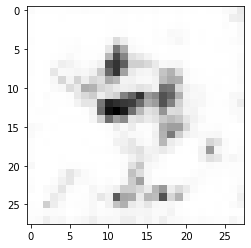

[0.41749856]
Progress: 10.95 %     Dloss: 12.12351    err: 1029.6023     Sample time: 0.058s    ___

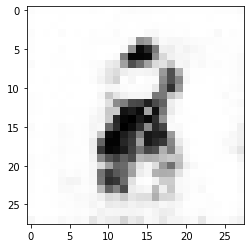

[0.47978035]
Progress: 12.32 %     Dloss: 11.5613    err: 735.7053     Sample time: 0.056s    _ ___

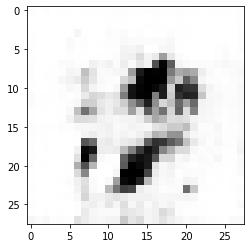

[0.49632704]
Progress: 13.69 %     Dloss: 11.3384495    err: 622.12244     Sample time: 0.057s    _

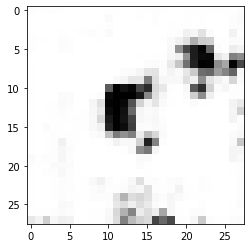

[0.29350233]
Progress: 15.06 %     Dloss: 12.633089    err: 616.5774     Sample time: 0.060s    ___

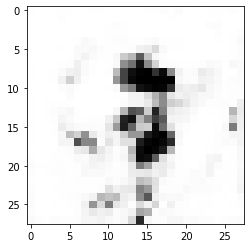

[0.484315]
Progress: 16.43 %     Dloss: 10.961329    err: 703.63477     Sample time: 0.059s    __

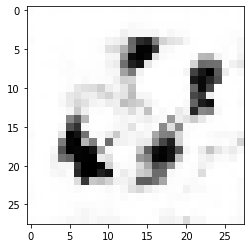

[0.51976067]
Progress: 17.81 %     Dloss: 9.973472    err: 670.6166     Sample time: 0.057s    _ _

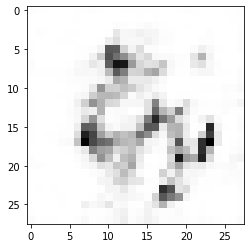

[0.6338117]
Progress: 19.18 %     Dloss: 10.201587    err: 742.11664     Sample time: 0.054s    _

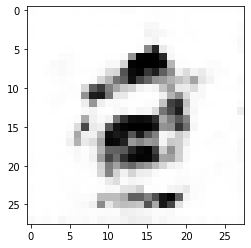

[0.44985273]
Progress: 20.55 %     Dloss: 9.878995    err: 669.85474     Sample time: 0.060s    __

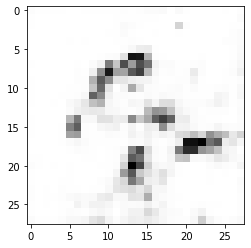

[0.47009972]
Progress: 21.92 %     Dloss: 9.212915    err: 620.8609     Sample time: 0.056s    ___

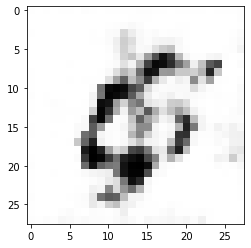

[0.4678246]
Progress: 23.29 %     Dloss: 10.838618    err: 651.83997     Sample time: 0.057s    __

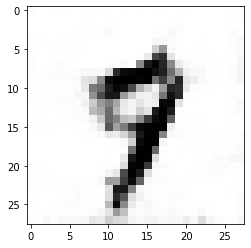

[0.5605035]
Progress: 24.66 %     Dloss: 11.37771    err: 726.631     Sample time: 0.058s    _ __

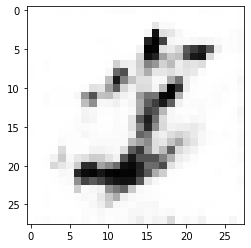

[0.46352375]
Progress: 26.03 %     Dloss: 8.311596    err: 635.6703     Sample time: 0.062s    ___

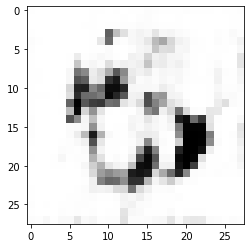

[0.1172512]
Progress: 27.41 %     Dloss: 9.62804    err: 682.09875     Sample time: 0.061s    _ _

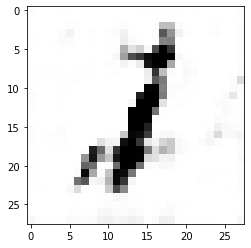

[0.3958582]
Progress: 28.78 %     Dloss: 9.882746    err: 786.801     Sample time: 0.062s    ____

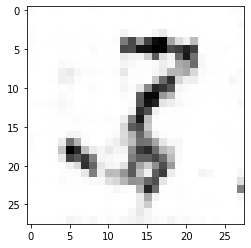

[0.5025117]
Progress: 30.15 %     Dloss: 8.820679    err: 633.3419     Sample time: 0.060s    _ _

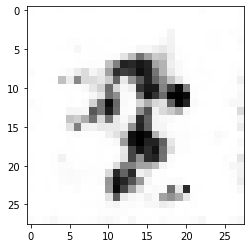

[0.6462242]
Progress: 31.52 %     Dloss: 9.507643    err: 735.281     Sample time: 0.057s    _  _

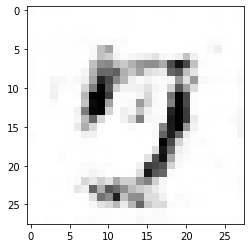

[0.39793772]
Progress: 32.89 %     Dloss: 9.20063    err: 694.73413     Sample time: 0.058s    ___

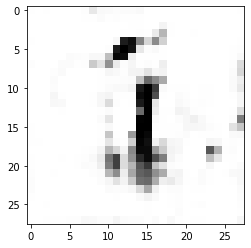

[0.41556054]
Progress: 34.26 %     Dloss: 12.46858    err: 599.2631     Sample time: 0.056s    ___

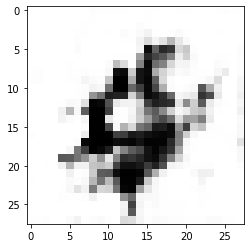

[0.5013455]
Progress: 35.63 %     Dloss: 9.177072    err: 844.5951     Sample time: 0.056s    _ _

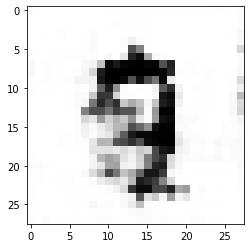

[0.5427894]
Progress: 37.01 %     Dloss: 9.083384    err: 814.2013     Sample time: 0.057s    _ _

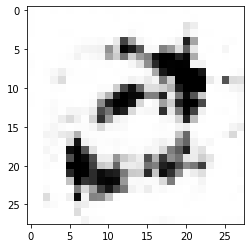

[0.21950081]
Progress: 38.38 %     Dloss: 11.102294    err: 672.5812     Sample time: 0.058s    __

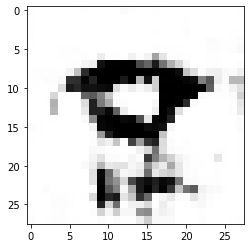

[0.19256331]
Progress: 39.75 %     Dloss: 15.488621    err: 760.7908     Sample time: 0.053s    __

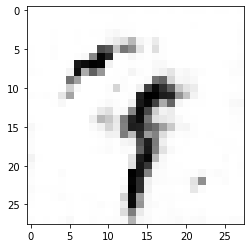

[0.50846845]
Progress: 41.12 %     Dloss: 11.656353    err: 793.78064     Sample time: 0.058s    __

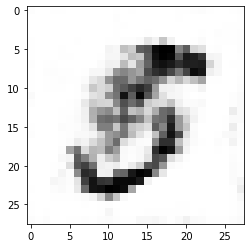

[0.6078859]
Progress: 42.49 %     Dloss: 9.181858    err: 917.77     Sample time: 0.060s    _  ___

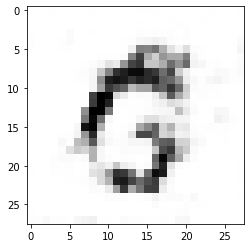

[0.52860147]
Progress: 43.86 %     Dloss: 9.3143215    err: 650.8002     Sample time: 0.058s    __

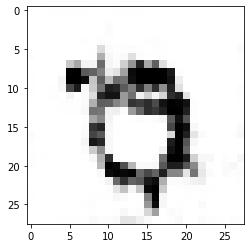

[0.43861008]
Progress: 45.23 %     Dloss: 11.526677    err: 638.6732     Sample time: 0.058s    __

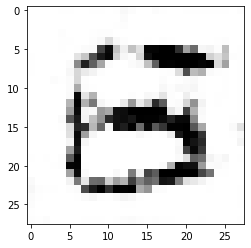

[0.31512108]
Progress: 46.61 %     Dloss: 9.070964    err: 735.39844     Sample time: 0.058s    __

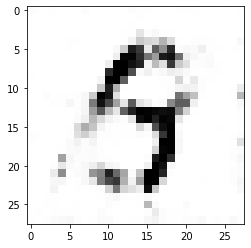

[0.53818893]
Progress: 47.98 %     Dloss: 12.069199    err: 810.23846     Sample time: 0.056s    _

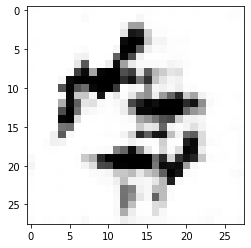

[0.15073478]
Progress: 49.35 %     Dloss: 10.933403    err: 772.05615     Sample time: 0.055s    _

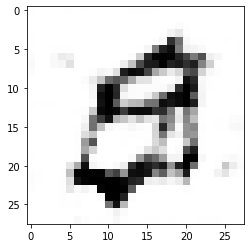

[0.35670587]
Progress: 50.72 %     Dloss: 12.101503    err: 728.56036     Sample time: 0.057s    _

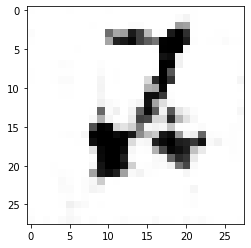

[0.18933097]
Progress: 52.09 %     Dloss: 6.902546    err: 847.6261     Sample time: 0.057s    ___

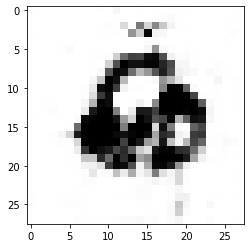

[0.10829674]
Progress: 53.46 %     Dloss: 11.359069    err: 768.2877     Sample time: 0.052s    ___

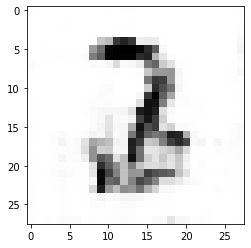

[0.50836945]
Progress: 54.83 %     Dloss: 10.448752    err: 661.9077     Sample time: 0.058s    __

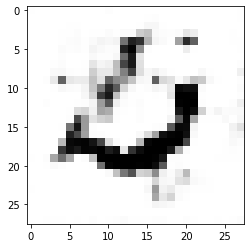

[0.29684713]
Progress: 56.21 %     Dloss: 9.508954    err: 736.92126     Sample time: 0.055s    __

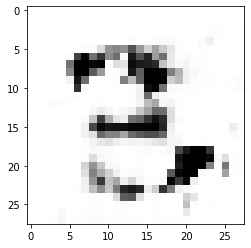

[0.4862403]
Progress: 57.58 %     Dloss: 8.826901    err: 850.6117     Sample time: 0.056s    ___

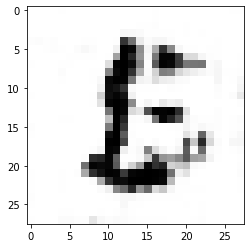

[0.30526242]
Progress: 58.95 %     Dloss: 10.6995945    err: 657.3898     Sample time: 0.069s    _

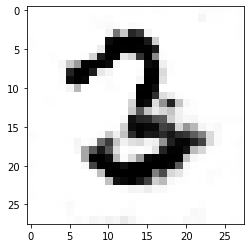

[0.35468778]
Progress: 60.32 %     Dloss: 8.917358    err: 724.0138     Sample time: 0.054s    _ _

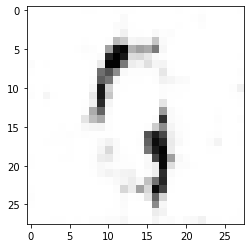

[0.55729496]
Progress: 61.69 %     Dloss: 12.29517    err: 722.95435     Sample time: 0.059s    __

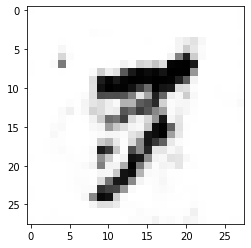

[0.6829968]
Progress: 63.06 %     Dloss: 12.304152    err: 900.1434     Sample time: 0.054s    __

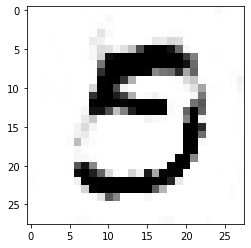

[0.41491348]
Progress: 64.43 %     Dloss: 9.562141    err: 557.6305     Sample time: 0.055s    _ _

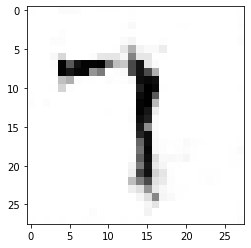

[0.50041497]
Progress: 65.81 %     Dloss: 10.269224    err: 767.9275     Sample time: 0.094s    ___

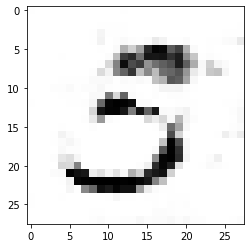

[0.7178452]
Progress: 67.18 %     Dloss: 11.154661    err: 702.4202     Sample time: 0.057s    ___

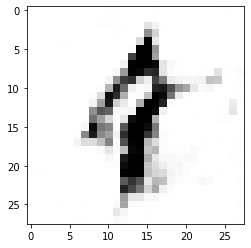

[0.61220485]
Progress: 68.55 %     Dloss: 9.525056    err: 691.35046     Sample time: 0.056s    ___

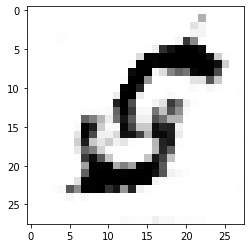

[0.1427295]
Progress: 69.92 %     Dloss: 12.250657    err: 718.3605     Sample time: 0.062s    __

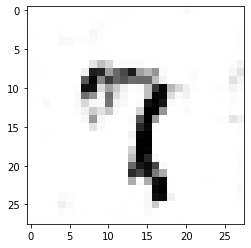

[0.21780975]
Progress: 71.29 %     Dloss: 7.783257    err: 542.68964     Sample time: 0.053s    __

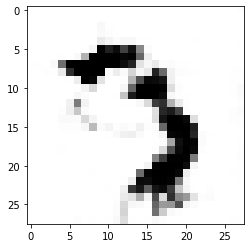

[0.2951615]
Progress: 72.66 %     Dloss: 8.17416    err: 585.8783     Sample time: 0.056s    __ __

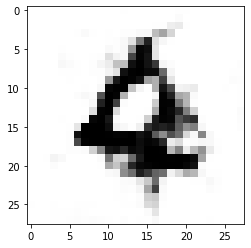

[0.43866342]
Progress: 74.03 %     Dloss: 8.92614    err: 745.96014     Sample time: 0.056s    ___

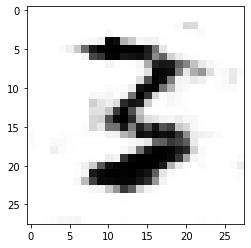

[0.764365]
Progress: 75.41 %     Dloss: 11.92207    err: 644.6525     Sample time: 0.060s    _ _

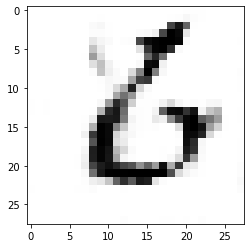

[0.46078846]
Progress: 76.78 %     Dloss: 9.196728    err: 699.4011     Sample time: 0.055s    _ __

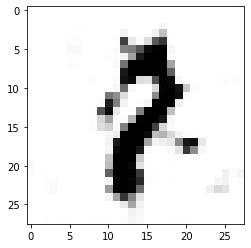

[0.2716561]
Progress: 78.15 %     Dloss: 8.006098    err: 575.4529     Sample time: 0.064s    ____

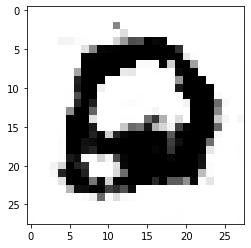

[0.62992585]
Progress: 79.52 %     Dloss: 9.304925    err: 646.9502     Sample time: 0.060s    _ _

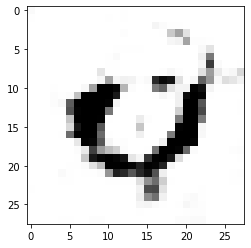

[0.1242036]
Progress: 80.89 %     Dloss: 13.049968    err: 622.2345     Sample time: 0.077s    __

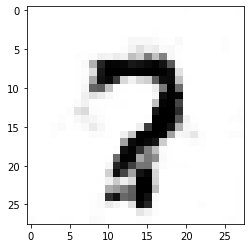

[0.3996836]
Progress: 82.26 %     Dloss: 9.444473    err: 624.58716     Sample time: 0.057s    __

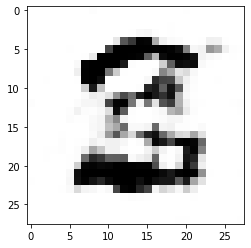

[0.6641947]
Progress: 83.63 %     Dloss: 9.611031    err: 647.5415     Sample time: 0.065s    ___

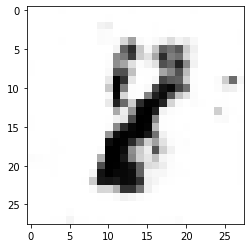

[0.43738806]
Progress: 85.01 %     Dloss: 9.486122    err: 507.46384     Sample time: 0.063s    __

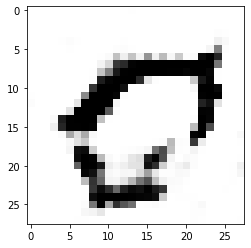

[0.22629878]
Progress: 86.38 %     Dloss: 9.636614    err: 670.40204     Sample time: 0.054s    ___

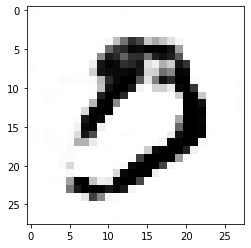

[0.5373699]
Progress: 87.75 %     Dloss: 8.811749    err: 610.05145     Sample time: 0.058s    __

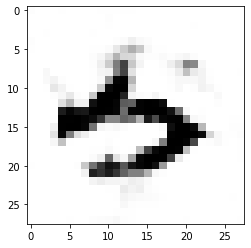

[0.46158955]
Progress: 89.12 %     Dloss: 11.445118    err: 615.59235     Sample time: 0.056s    __

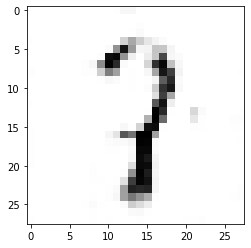

[0.545865]
Progress: 90.49 %     Dloss: 10.964721    err: 570.9253     Sample time: 0.053s    __

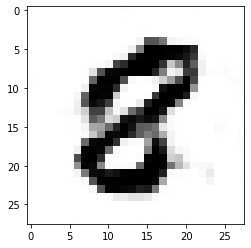

[0.2407291]
Progress: 91.86 %     Dloss: 12.615607    err: 642.79114     Sample time: 0.053s    _

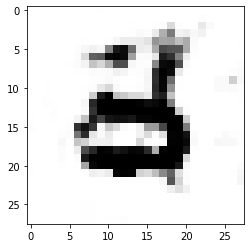

[0.41880986]
Progress: 93.23 %     Dloss: 11.391821    err: 570.1606     Sample time: 0.054s    __

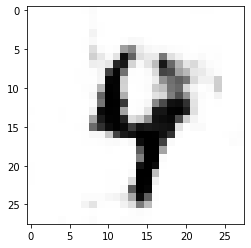

[0.752138]
Progress: 94.61 %     Dloss: 10.496038    err: 581.1574     Sample time: 0.056s    ___

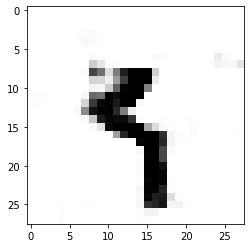

[0.2220687]
Progress: 95.98 %     Dloss: 9.790908    err: 656.5766     Sample time: 0.058s    ____

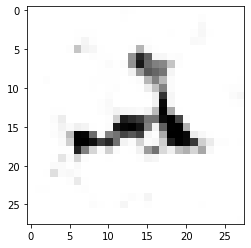

[0.57346416]
Progress: 97.35 %     Dloss: 7.13373    err: 666.062     Sample time: 0.055s    _  __

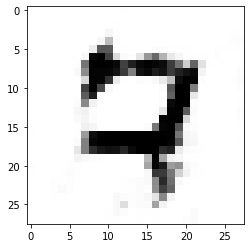

[0.43583813]
Progress: 98.72 %     Dloss: 9.384537    err: 588.75806     Sample time: 0.055s    __

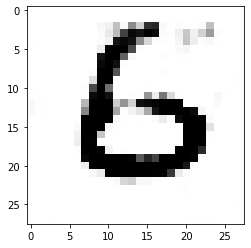

[0.54278433]
Progress: 99.98 %     Dloss: 8.189862    err: 569.3325     Sample time: 0.054s    ___
Epoch time: 9:6s


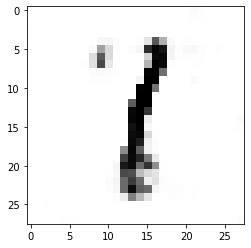

[0.83947796]
EPOCH: 2 / 5


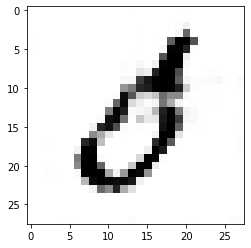

[0.69609946]
Progress: 1.35 %     Dloss: 6.605476    err: 678.3154     Sample time: 0.056s    ____

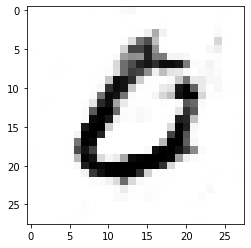

[0.55640125]
Progress: 2.72 %     Dloss: 12.708578    err: 668.4623     Sample time: 0.056s    ___

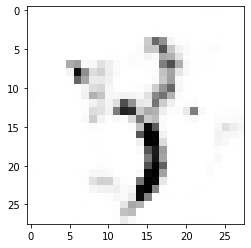

[0.5198634]
Progress: 4.09 %     Dloss: 9.413627    err: 666.05225     Sample time: 0.055s    ___

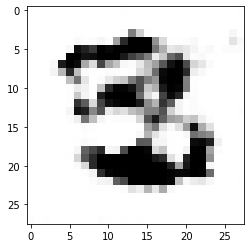

[0.34827548]
Progress: 5.46 %     Dloss: 8.547107    err: 594.8363     Sample time: 0.059s    _ _

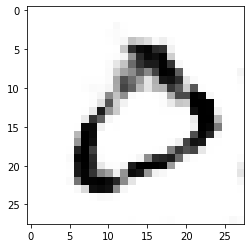

[0.5620383]
Progress: 6.83 %     Dloss: 10.046672    err: 929.32324     Sample time: 0.054s    _

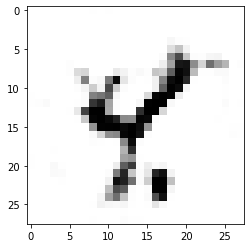

[0.38996518]
Progress: 8.21 %     Dloss: 8.634477    err: 661.04095     Sample time: 0.053s    ___

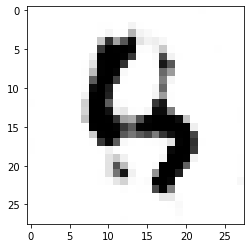

[0.28096303]
Progress: 9.58 %     Dloss: 10.018389    err: 589.6534     Sample time: 0.063s    __

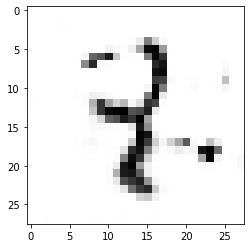

[0.33054942]
Progress: 10.95 %     Dloss: 8.916957    err: 629.7731     Sample time: 0.055s    ___

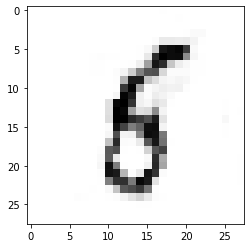

[0.49795207]
Progress: 12.32 %     Dloss: 11.549311    err: 453.251     Sample time: 0.054s    _ _

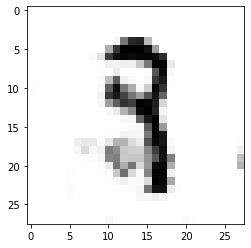

[0.49737552]
Progress: 13.69 %     Dloss: 9.396746    err: 668.199     Sample time: 0.059s    _ ___

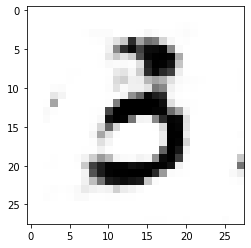

[0.5266687]
Progress: 15.06 %     Dloss: 9.454707    err: 625.69354     Sample time: 0.053s    __

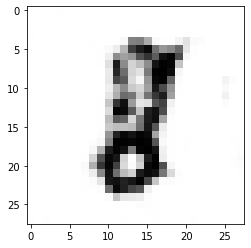

[0.5265466]
Progress: 16.43 %     Dloss: 9.896824    err: 666.9242     Sample time: 0.058s    ___

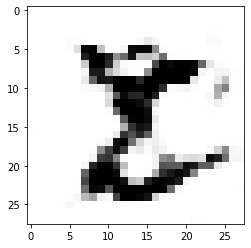

[0.3359797]
Progress: 17.81 %     Dloss: 8.693892    err: 691.5554     Sample time: 0.058s    ___

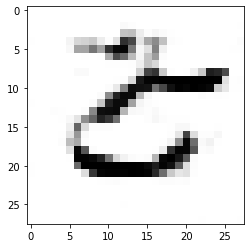

[0.6457507]
Progress: 19.18 %     Dloss: 11.882275    err: 606.7741     Sample time: 0.055s    ___

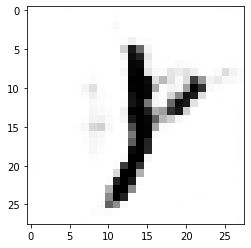

[0.6218633]
Progress: 20.55 %     Dloss: 8.248736    err: 650.6189     Sample time: 0.056s    _ __

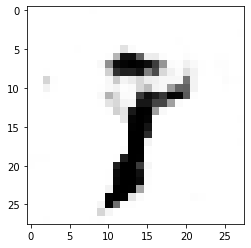

[0.41355616]
Progress: 21.92 %     Dloss: 8.119087    err: 759.93866     Sample time: 0.055s    ___

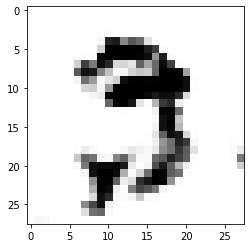

[0.43400255]
Progress: 23.29 %     Dloss: 12.693052    err: 590.90515     Sample time: 0.053s    _

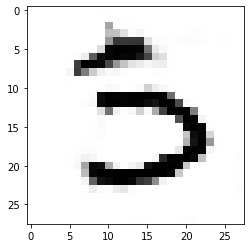

[0.20133673]
Progress: 24.66 %     Dloss: 10.729841    err: 582.4869     Sample time: 0.055s    __

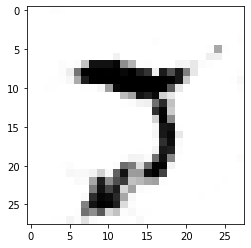

[0.19812497]
Progress: 26.03 %     Dloss: 8.0394745    err: 767.622     Sample time: 0.057s    ___

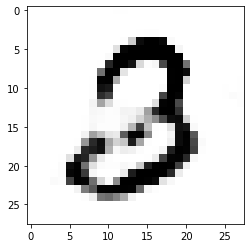

[0.41231248]
Progress: 27.41 %     Dloss: 11.670153    err: 680.46765     Sample time: 0.059s    _

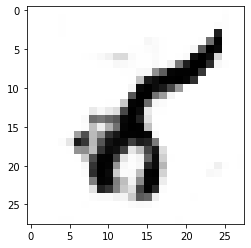

[0.608871]
Progress: 28.78 %     Dloss: 7.8753934    err: 605.027     Sample time: 0.066s    _ _

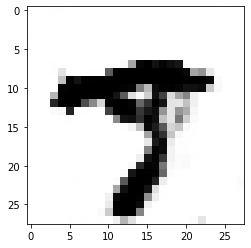

[0.60292566]
Progress: 30.15 %     Dloss: 11.28675    err: 748.3503     Sample time: 0.057s    ___

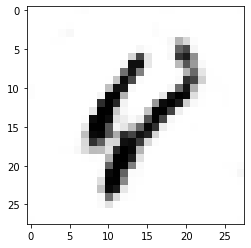

[0.6124169]
Progress: 31.52 %     Dloss: 7.3670654    err: 548.9192     Sample time: 0.056s    __

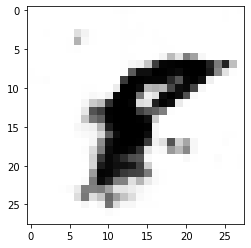

[0.37094846]
Progress: 32.89 %     Dloss: 11.004189    err: 610.0667     Sample time: 0.060s    __

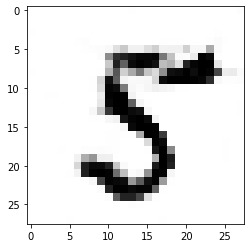

[0.54584837]
Progress: 34.26 %     Dloss: 7.4496293    err: 670.0006     Sample time: 0.052s    __

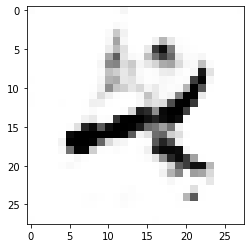

[0.7972833]
Progress: 35.63 %     Dloss: 11.016678    err: 803.56287     Sample time: 0.052s    _

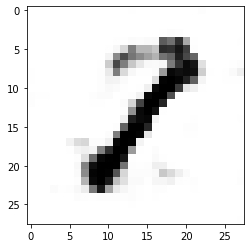

[0.3858789]
Progress: 37.01 %     Dloss: 10.54568    err: 687.74133     Sample time: 0.046s    ___

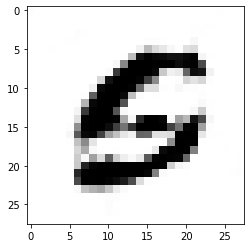

[0.17213334]
Progress: 38.38 %     Dloss: 7.7083263    err: 631.1072     Sample time: 0.044s    ___

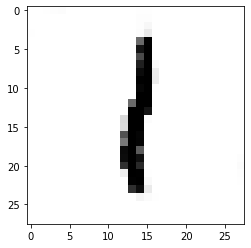

[0.8672038]
Progress: 39.75 %     Dloss: 9.100298    err: 643.797     Sample time: 0.053s    _ __

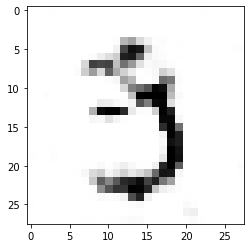

[0.29394966]
Progress: 41.12 %     Dloss: 9.339031    err: 699.76965     Sample time: 0.054s    __

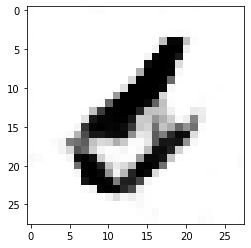

[0.28538585]
Progress: 42.49 %     Dloss: 8.864509    err: 620.1222     Sample time: 0.054s    ____

KeyboardInterrupt: 

In [14]:
epochs=5
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run(16)
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))
    gen_sample()

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

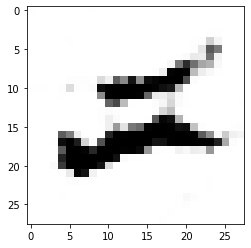

[0.77684766]


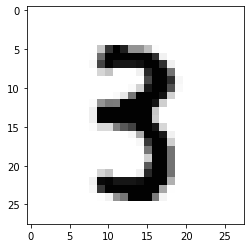

[[0.5759623]]


In [20]:
noise=cp.random.randn(128,100,dtype=cp.float32)
gen=g.predict(noise)
gen_sample()
img=X_train[cp.random.randint(low=0,high=X_train.shape[0],size=1)]
plt.imshow(((img.reshape(28,28)+1)/2).get(), cmap='Greys')
plt.show()
print(d.predict(img))

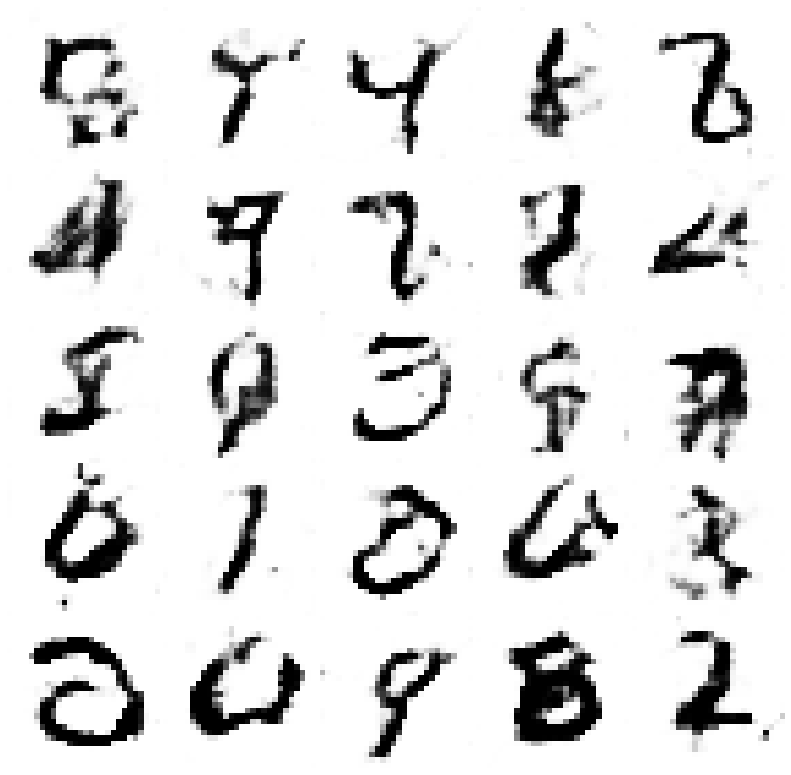

In [24]:
fig, ax = plt.subplots(nrows=5,ncols=5,figsize=[14,14],gridspec_kw = {'wspace':0, 'hspace':0})
fig.patch.set_facecolor('white')
noise=cp.random.randn(25,100,dtype=cp.float32)
gen=g.predict(noise)
for i,axi in enumerate(ax.flat):
    axi.axis("off")
    axi.imshow(((gen[i].squeeze()+1)/2).get(), cmap='Greys')